# Gausian States and Gates

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
from matplotlib import cm

covMatrix = np.array([[0.5, 0], [0, 0.5]])
mean = np.zeros(2) # This would be our r-bar for the vacuum state

x_vals = np.linspace(-5, 5, 100)  # X quadrature range
p_vals = np.linspace(-5, 5, 100)  # P quadrature range

# Create a grid of (x, p) values
X, P = np.meshgrid(x_vals, p_vals)
grid_points = np.stack([X.ravel(), P.ravel()], axis=-1)  # shape (10000,2)

diff = grid_points - mean

invCovM =  np.linalg.inv(covMatrix)
detCovM =  np.linalg.det(covMatrix)


In [ ]:
def GaussianDistribution(diff, det, inv_cov):
    
    # Calculate the exponent for all points at once
    exponent = -0.5 * np.einsum('ni,ij,nj->n', diff, inv_cov, diff)
    
    return (1/(2*np.pi * np.sqrt(det))) * np.exp(exponent)

def WignerCalc(diff, det, inv_cov):
    return GaussianDistribution(diff, det, inv_cov).reshape(X.shape)

W = WignerCalc(diff, detCovM, invCovM)
W.shape

(100, 100)

In [12]:
def ApplyTransformationAndDisplacement(cov, r, F, d):
    transformed_cov = F @ cov @ F.T
    transformed_r = F@r + d
    return transformed_cov, transformed_r

In [13]:
alpha = 2 + 2j
F_Displacement = np.eye(2)
d_Displacement = np.array([alpha.real, alpha.imag])

In [14]:
# Applying the operations
CoherentCovMatrix, CoherentMean = ApplyTransformationAndDisplacement(covMatrix, mean, F_Displacement, d_Displacement)

diff_Co = grid_points - CoherentMean
invCovM_Co =  np.linalg.inv(CoherentCovMatrix)
detCovM_Co =  np.linalg.det(CoherentCovMatrix)

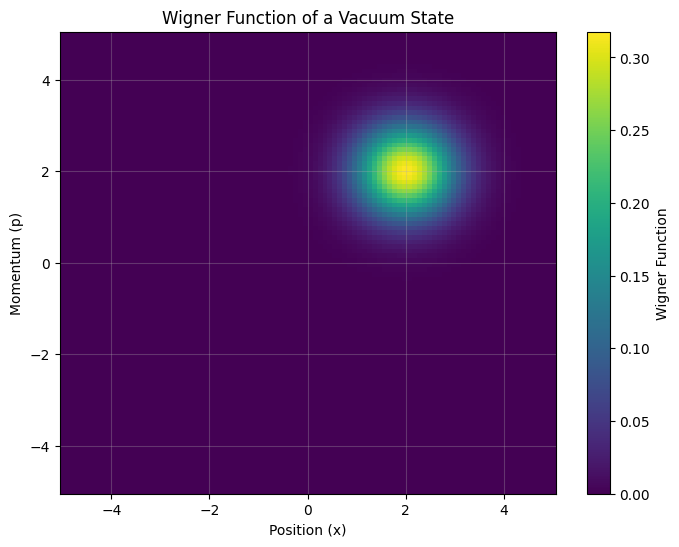

In [15]:
# Compute Wigner function over the grid
W = WignerCalc(diff_Co, detCovM_Co, invCovM_Co)

plt.figure(figsize=(8, 6))
plt.pcolormesh(X, P, W, shading='auto', cmap='viridis')
plt.colorbar(label='Wigner Function')
plt.xlabel('Position (x)')
plt.ylabel('Momentum (p)')
plt.title('Wigner Function of a Vacuum State')
plt.grid(alpha=0.3)
plt.show()

In [16]:
def plot_wigner(r, theta, alpha_real, alpha_imag, angle_view):
    # Create displacement vector from α
    d_Displacement = np.array([alpha_real, alpha_imag])

    # Squeezing
    F_squeezing = np.cosh(r) * np.eye(2) + np.sinh(r) * np.array([[np.cos(theta), np.sin(theta)], [np.sin(theta), -np.cos(theta)]])
    d_squeezing = np.zeros(2)  # No displacement for squeezing

    # Apply squeezing
    SqzcovMatrix,Sqzmean = ApplyTransformationAndDisplacement(covMatrix, mean, F_squeezing, d_squeezing)

    # Apply displacement
    CoherentCovMatrix, CoherentMean = ApplyTransformationAndDisplacement(
        SqzcovMatrix, Sqzmean, F_Displacement, d_Displacement)
    
    
    invCovM =  np.linalg.inv(CoherentCovMatrix)
    detCovM =  np.linalg.det(CoherentCovMatrix)

    diff = grid_points - CoherentMean
    W = WignerCalc(diff, detCovM, invCovM)

    # 2D Plot
    # Create figure with adjusted dimensions and GridSpec
    fig = plt.figure(figsize=(18, 8))
    gs = plt.GridSpec(1, 2, width_ratios=[1, 1.2])  # 1:1.2 width ratio
    
    # 2D Plot (left subplot) - Now square
    ax1 = fig.add_subplot(gs[0])
    pcm = ax1.pcolormesh(X, P, W, shading='auto', cmap='viridis')
    fig.colorbar(pcm, ax=ax1, label='Wigner Function')
    ax1.set_xlabel('Position (x)')
    ax1.set_ylabel('Momentum (p)')
    ax1.set_title(f'Wigner Function (α = {alpha_real:.1f} + {alpha_imag:.1f}i)')
    ax1.grid(alpha=0.3)
    ax1.set_aspect('equal')  # This makes the plot square
    
    # 3D Plot (right subplot)
    ax2 = fig.add_subplot(122, projection='3d')
    surf = ax2.plot_surface(X, P, W, rstride=1, cstride=1, 
                          cmap=cm.Blues, edgecolor='k', 
                          linewidth=0.05, antialiased=True)
    
    # Customize 3D plot
    ax2.xaxis.pane.fill = False
    ax2.yaxis.pane.fill = False
    ax2.zaxis.pane.fill = False
    ax2.set_xlabel('X')
    ax2.set_ylabel('P')
    #ax2.set_zlabel('Wigner Function')
    ax2.set_zlim(np.min(W), np.max(W))
    ax2.view_init(25, angle_view)  # Better viewing angle
    #fig.colorbar(surf, ax=ax2, label='Wigner Function')
    
    plt.tight_layout()
    plt.show()

# Create interactive widget
interact(
    plot_wigner,
    r=FloatSlider(value=0, min=0, max=1, step=0.1, description='Sqz r:'),
    theta=FloatSlider(value=0, min=-np.pi, max=np.pi, step=0.1*np.pi, description='Sqz theta:'),
    alpha_real=FloatSlider(value=0, min=-4, max=4, step=0.1, description='Re(α):'),
    alpha_imag=FloatSlider(value=0, min=-4, max=4, step=0.1, description='Im(α):'),
    angle_view=FloatSlider(value=45, min=-180, max=180, step=0.1, description='View angle:')
)

interactive(children=(FloatSlider(value=0.0, description='Sqz r:', max=1.0), FloatSlider(value=0.0, descriptio…

<function __main__.plot_wigner(r, theta, alpha_real, alpha_imag, angle_view)>

In [17]:
import scipy as sp

def Wmn(m, n, x, p):
    if m < n:
        return np.conj(Wmn(n, m, x, p))  # Use symmetry
    else:
        # Calculate the generalized Laguerre polynomial
        L = sp.special.genlaguerre(n, m-n)(2*x**2 + 2*p**2)
        return (1/np.pi) * np.exp(-x**2 - p**2) * (-1)**n * (x - 1j*p)**(m-n) * np.sqrt(2**(m-n) * sp.special.factorial(n) / sp.special.factorial(m)) * L

covMatrix_test = np.array([[0.5, 0], [0, 0.5]]) # Covariance matrix of a vacuum state
mean_test = np.zeros(2) # This would be our r-bar

invCovM =  np.linalg.inv(covMatrix_test)
detCovM =  np.linalg.det(covMatrix_test)
diff = grid_points - mean_test
W = WignerCalc(diff, detCovM, invCovM)

# Making our size limit
size_limit = 3  # Arbitrary size limit for the matrix
rho = np.zeros((size_limit, size_limit), dtype=complex)

In [ ]:
# Here we use the SciPy integration to compute the density matrix
# It is very precise but also very slow

# Making our size limit
size_limit = 3  # Arbitrary size limit for the matrix
'''
def GaussianDistribution_scalar(mean, det, inv_cov, x, p):
    """Version that works with scalar x,p values (for integration)"""
    r = np.array([x, p])
    diff = r - mean
    exponent = -0.5 * np.einsum('i,ij,j->', diff, inv_cov, diff)
    return (1/(2*np.pi * np.sqrt(det))) * np.exp(exponent)
'''
# Modified integration loop
rho = np.zeros((size_limit, size_limit), dtype=complex)

In [19]:
# And here we do things the old-fashioned way, which is much faster but less accurate
x_step = x_vals[1] - x_vals[0]
p_step = p_vals[1] - p_vals[0]

def W2rho():
    for m in range(size_limit):
        for n in range(size_limit):
            # Integrate the Wigner function with the Wmn function
            integral = np.sum(W * Wmn(m, n, X, P)) * (x_step) * (p_step)
            rho[m, n] = 2 * np.pi * integral
    return rho

%timeit W2rho()

2.93 ms ± 136 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
def plot_wigner(r, theta, alpha_real, alpha_imag, angle_view, size_limit):
    # Create displacement vector from α
    d_Displacement = np.array([alpha_real, alpha_imag])

    # Squeezing
    F_squeezing = np.cosh(r) * np.eye(2) + np.sinh(r) * np.array([[np.cos(theta), np.sin(theta)], [np.sin(theta), -np.cos(theta)]])
    d_squeezing = np.zeros(2)  # No displacement for squeezing

    # Apply squeezing
    SqzcovMatrix,Sqzmean = ApplyTransformationAndDisplacement(covMatrix, mean, F_squeezing, d_squeezing)

    # Apply displacement
    CoherentCovMatrix, CoherentMean = ApplyTransformationAndDisplacement(
        SqzcovMatrix, Sqzmean, F_Displacement, d_Displacement)
    
    # Compute Wigner function
    invCovM =  np.linalg.inv(CoherentCovMatrix)
    detCovM =  np.linalg.det(CoherentCovMatrix)

    diff = grid_points - CoherentMean
    W = WignerCalc(diff, detCovM, invCovM)

    
    # Compute density matrix
    rho = np.zeros((size_limit, size_limit), dtype=complex)

    for m in range(size_limit):
        for n in range(size_limit):
        # Integrate the Wigner function with the Wmn function
            integral = np.sum(W * Wmn(m, n, X, P)) * (x_step) * (p_step)
            rho[m, n] = 2 * np.pi * integral
    
    # Display Photon Number Statistics
    number_values = np.arange(0, size_limit)
    number_prob = [rho[m, m] for m in range(size_limit)]


    # 2D Plot
    # Create figure with adjusted dimensions and GridSpec
    fig = plt.figure(figsize=(18, 8))
    gs = plt.GridSpec(1, 2, width_ratios=[1, 1.2])  # 1:1.2 width ratio
    
    # 2D Plot (left subplot) - Now square
    ax1 = fig.add_subplot(gs[0])
    pcm = ax1.pcolormesh(X, P, W, shading='auto', cmap='viridis')
    fig.colorbar(pcm, ax=ax1, label='Wigner Function')
    ax1.set_xlabel('Position (x)')
    ax1.set_ylabel('Momentum (p)')
    ax1.set_title(f'Wigner Function (α = {alpha_real:.1f} + {alpha_imag:.1f}i)')
    ax1.grid(alpha=0.3)
    ax1.set_aspect('equal')  # This makes the plot square
    
    # 3D Plot (right subplot)
    ax2 = fig.add_subplot(122, projection='3d')
    surf = ax2.plot_surface(X, P, W, rstride=1, cstride=1, 
                          cmap=cm.Blues, edgecolor='k', 
                          linewidth=0.05, antialiased=True)
    
    # Customize 3D plot
    ax2.xaxis.pane.fill = False
    ax2.yaxis.pane.fill = False
    ax2.zaxis.pane.fill = False
    ax2.set_xlabel('X')
    ax2.set_ylabel('P')
    #ax2.set_zlabel('Wigner Function')
    ax2.set_zlim(np.min(W), np.max(W))
    ax2.view_init(25, angle_view)  # Better viewing angle
    #fig.colorbar(surf, ax=ax2, label='Wigner Function')
    
    plt.tight_layout()
    plt.show()

    # Plot for Photon Number Statistics
    plt.figure(figsize=(10, 6))
    plt.bar(number_values, number_prob, color='skyblue', width=0.4, tick_label=number_values)
    plt.xlabel('Photon Number (n)')
    plt.ylabel('Probability')
    plt.title('Photon Number Statistics')


# Create interactive widget
interact(
    plot_wigner,
    r=FloatSlider(value=0, min=0, max=1, step=0.1, description='Sqz r:'),
    theta=FloatSlider(value=0, min=-np.pi, max=np.pi, step=0.1*np.pi, description='Sqz theta [rad]:'),
    alpha_real=FloatSlider(value=0, min=-4, max=4, step=0.1, description='Re(α):'),
    alpha_imag=FloatSlider(value=0, min=-4, max=4, step=0.1, description='Im(α):'),
    angle_view=FloatSlider(value=60, min=-180, max=180, step=1, description='View angle [degr]:'),
    size_limit=IntSlider(value=20, min=1, max=30, step=1, description='Number of modes:')
)

interactive(children=(FloatSlider(value=0.0, description='Sqz r:', max=1.0), FloatSlider(value=0.0, descriptio…

<function __main__.plot_wigner(r, theta, alpha_real, alpha_imag, angle_view, size_limit)>

In [54]:
# Let's try and make an even cat state
alpha = np.sqrt(5)

F_Displacement = np.eye(2)
d_a = np.array([alpha.real, alpha.imag])

beta = -1*alpha
Ne = np.sqrt(1/2) * (1 + np.exp( -2* (alpha**2) )**(-0.5))
d_b = np.array([beta.real, beta.imag])


def GaussianDistribution(diff, det, inv_cov):
    
    # Calculate the exponent for all points at once
    exponent = -0.5 * np.einsum('ni,ij,nj->n', diff, inv_cov, diff)
    
    return (1/(2*np.pi * np.sqrt(det))) * np.exp(exponent)

def WignerCalc(diff, det, inv_cov):
    return GaussianDistribution(diff, det, inv_cov).reshape(X.shape)


In [60]:
#mu = np.sqrt(1/2) * np.array([  (alpha+beta).real + 1j * (alpha-beta).imag , (alpha+beta).imag + 1j * (beta - alpha).real] )

d = -0.5 * (alpha - beta).imag **2 -0.5 * (alpha-beta).real **2 - 1j*beta.imag*alpha.real + 1j*alpha.real*beta.imag
c = np.log(Ne) + np.log(Ne) + d

In [61]:
combinations = np.array([
    [alpha + alpha],  # α+α
    [alpha + beta],   # α+β
    [beta + alpha],   # β+α
    [beta + beta]     # β+β
])  # Shape (4,1,1)

# Calculate μ for all combinations (vectorized)
real_part = np.real(combinations)
imag_part = np.imag(combinations)

mu = np.sqrt(1/2) * np.stack([
    real_part + 1j*imag_part,  # Re(α±β) + i Im(α∓β)
    imag_part + 1j*(-real_part) # Im(α±β) + i Re(β-α)
], axis=1)  # Result shape (4,2,1)

mu

array([[[ 3.16227766+0.j        ],
        [ 0.        -3.16227766j]],

       [[ 0.        +0.j        ],
        [ 0.        +0.j        ]],

       [[ 0.        +0.j        ],
        [ 0.        +0.j        ]],

       [[-3.16227766+0.j        ],
        [ 0.        +3.16227766j]]])

In [57]:
# Assuming you already have:
# - grid_points (shape: Nx2)
# - mu (shape: 4x2x1)
# - c (scalar)
# - det (scalar)
# - inv_cov (2x2 matrix)

# 1. Reshape mu for broadcasting (4x2x1 -> 4x1x2)
mu_reshaped = np.squeeze(mu, axis=-1)  # now shape (4,2)

# 2. Compute differences (Nx2 minus each 4x2 -> 4xNx2)
diff = grid_points[:, np.newaxis, :] - mu_reshaped  # shape (N,4,2)

# 3. Compute Wigner for all differences
# Vectorized computation for all 4 cases simultaneously
wigners = np.array([WignerCalc(diff[:,i,:], detCovM, invCovM) for i in range(4)])  # shape (4,N)

# 4. Compute final result
result = np.exp(c) * np.sum(wigners, axis=0)  # shape (N,)

# Reshape back to original grid if needed
result_grid = result.reshape(X.shape)  # if you need (100,100) shape

c:\Users\liqiz\Desktop\Semester 3\Scientific Computing in Quantum Information Science\CV_Simulation\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


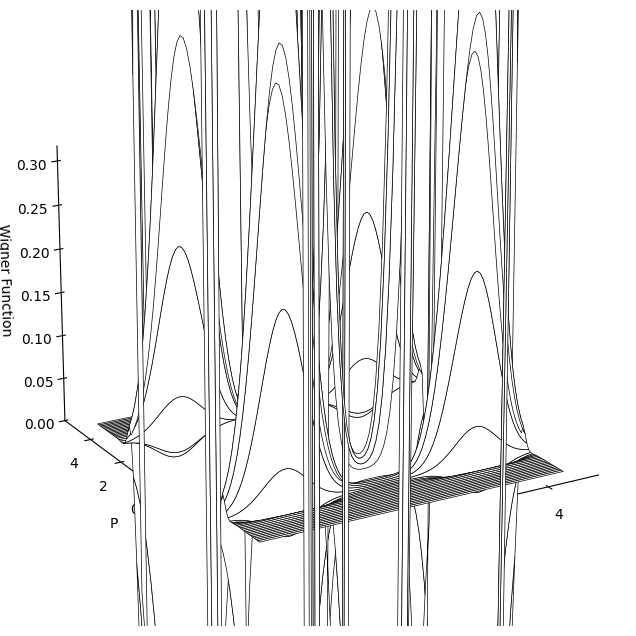

In [58]:
# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the Wigner function
#ax.plot_surface(X, P, W, rstride=1, cstride=1, cmap='RdBu', edgecolor='k', lw=0.5, alpha=1.0)
ax.plot_surface(X, P, result_grid, rstride=1, cstride=100000, color='w', edgecolor='k', shade=False, lw=.5, alpha=1)

# Customize the plot
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.yaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.zaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.grid(False)

# Set labels and limits
ax.set_xlabel('X')
ax.set_ylabel('P')
ax.set_zlabel('Wigner Function')
ax.set_zlim(np.min(W), np.max(W))
ax.view_init(20, -120)  # Adjust the viewing angle

plt.show()

c:\Users\liqiz\Desktop\Semester 3\Scientific Computing in Quantum Information Science\CV_Simulation\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


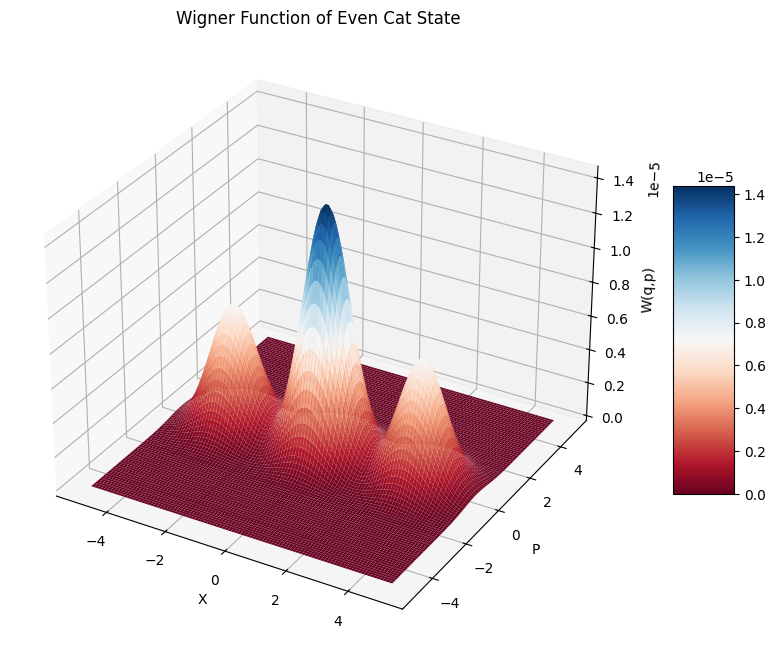

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters
alpha = np.sqrt(5)
beta = -alpha
hbar = 1  # Setting ℏ=2 to match your scaling

# Correct normalization for even cat state
Ne = 1 / np.sqrt(2 * (1 + np.exp(-2 * np.abs(alpha)**2)))

# Correct d calculation
d = (-0.5 * (alpha - beta).imag**2 - 0.5 * (alpha - beta).real**2 
     - 1j*beta.imag*alpha.real + 1j*alpha.imag*beta.real)

# Combined coefficient
c = 2*np.log(Ne) + d  # Total prefactor

# Covariance matrix (ℏ/2 * identity)
cov = (hbar/2) * np.eye(2)
inv_cov = np.linalg.inv(cov)
det = np.linalg.det(cov)

# Create grid
x = np.linspace(-5, 5, 100)
p = np.linspace(-5, 5, 100)
X, P = np.meshgrid(x, p)
grid_points = np.stack([X.ravel(), P.ravel()], axis=-1)

# μ calculations (simplified for β=-α)
mu_terms = [
    np.sqrt(hbar/2) * np.array([2*alpha.real, 2*alpha.imag]),  # α+α
    np.sqrt(hbar/2) * np.array([0j, 0j]),                      # α+β (=0)
    np.sqrt(hbar/2) * np.array([0j, 0j]),                      # β+α (=0)
    np.sqrt(hbar/2) * np.array([2*beta.real, 2*beta.imag])     # β+β
]

# Compute Wigner terms
wigner_terms = []
for mu in mu_terms:
    diff = grid_points - mu
    exponent = -0.5 * np.einsum('ni,ij,nj->n', diff, inv_cov, diff)
    wigner = (1/(2*np.pi * np.sqrt(det))) * np.exp(exponent)
    wigner_terms.append(wigner.reshape(X.shape))

# Combine terms with correct coefficients
W = np.exp(c) * (wigner_terms[0] + wigner_terms[1] + wigner_terms[2] + wigner_terms[3])

# Ensure reality (numerical cleanup)
#W = np.real(W)

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, P, W, cmap='RdBu', rstride=1, cstride=1, 
                      edgecolor='none', antialiased=True)

ax.set_xlabel('X')
ax.set_ylabel('P')
ax.set_zlabel('W(q,p)')
ax.set_title('Wigner Function of Even Cat State')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()